# Olympics Capstone — Consolidated Notebook

This merged notebook combines Milestones 1–4 (SQL + Python analysis, EDA, modeling, and storytelling). Run cells sequentially. Data path expected: `C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data`.


---

## Included from `milestone1_sql_analysis.ipynb`

# Milestone 1 — SQL Analysis (SQLite)




In [1]:
# Setup: imports + data path
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Local data path (update if different)
data_dir = Path(r"C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data")
athletes_fp = data_dir / "athlete_events.csv"
noc_fp = data_dir / "noc_regions.csv"

print("Using data path:", athletes_fp)
if not athletes_fp.exists():
    raise FileNotFoundError(f"athlete_events.csv not found at {athletes_fp}. Place the CSV in this folder and re-run the notebook.")
# load CSV into pandas
df = pd.read_csv(athletes_fp, low_memory=False)
print("Loaded CSV with shape:", df.shape)
# standard helpers
df['Year'] = df['Year'].astype(int)
df['is_medal'] = df['Medal'].notna()


Using data path: C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data\athlete_events.csv
Loaded CSV with shape: (271116, 15)


## Create in-memory SQLite DB and load dataframe as a SQL table

In [2]:
# Create in-memory SQLite DB and populate 'olympics' table
conn = sqlite3.connect(':memory:')
df.to_sql('olympics', conn, index=False, if_exists='replace')
print('Table olympics created in SQLite in-memory DB')

Table olympics created in SQLite in-memory DB


## SQL: Medals over time (example query)

In [3]:
import pandas as pd
query = '''
SELECT Year, COUNT(Medal) AS total_medals
FROM olympics
WHERE Medal IS NOT NULL
GROUP BY Year
ORDER BY Year;
'''
medals_over_time = pd.read_sql_query(query, conn)
medals_over_time.head()

,Year,total_medals
0,1896,143
1,1900,604
2,1904,486
3,1906,458
4,1908,831


## SQL: Top 10 sports by medal count

In [4]:
query = '''
SELECT Sport, COUNT(Medal) AS medal_count
FROM olympics
WHERE Medal IS NOT NULL
GROUP BY Sport
ORDER BY medal_count DESC
LIMIT 10;
'''
top_sports_sql = pd.read_sql_query(query, conn)
top_sports_sql

,Sport,medal_count
0,Athletics,3969
1,Swimming,3048
2,Rowing,2945
3,Gymnastics,2256
4,Fencing,1743
5,Football,1571
6,Ice Hockey,1530
7,Hockey,1528
8,Wrestling,1296
9,Cycling,1263


## SQL: Top 10 NOCs by medal count

In [5]:
query = '''
SELECT NOC, COUNT(Medal) AS medal_count
FROM olympics
WHERE Medal IS NOT NULL
GROUP BY NOC
ORDER BY medal_count DESC
LIMIT 10;
'''
top_nocs_sql = pd.read_sql_query(query, conn)
top_nocs_sql

,NOC,medal_count
0,USA,5637
1,URS,2503
2,GER,2165
3,GBR,2068
4,FRA,1777
5,ITA,1637
6,SWE,1536
7,CAN,1352
8,AUS,1320
9,RUS,1165


## SQL: Gender participation per year (athlete counts)

In [6]:
query = '''
SELECT Year, Sex, COUNT(DISTINCT ID) AS athletes_count
FROM olympics
GROUP BY Year, Sex
ORDER BY Year;
'''
gender_participation = pd.read_sql_query(query, conn)
gender_participation.head()

,Year,Sex,athletes_count
0,1896,M,176
1,1900,F,23
2,1900,M,1201
3,1904,F,6
4,1904,M,644


## Notes
- These queries run on an **in-memory** SQLite database created from the CSV. 
- For larger/external DBs use PostgreSQL and the loader script.

---

## Included from `milestone2_descriptive.ipynb`

# Milestone 2 — Descriptive Analysis (SQL + Python)




In [7]:
# Setup: imports + data path
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Local data path (update if different)
data_dir = Path(r"C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data")
athletes_fp = data_dir / "athlete_events.csv"
noc_fp = data_dir / "noc_regions.csv"

print("Using data path:", athletes_fp)
if not athletes_fp.exists():
    raise FileNotFoundError(f"athlete_events.csv not found at {athletes_fp}. Place the CSV in this folder and re-run the notebook.")
# load CSV into pandas
df = pd.read_csv(athletes_fp, low_memory=False)
print("Loaded CSV with shape:", df.shape)
# standard helpers
df['Year'] = df['Year'].astype(int)
df['is_medal'] = df['Medal'].notna()


Using data path: C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data\athlete_events.csv
Loaded CSV with shape: (271116, 15)


In [8]:
# Create in-memory SQLite DB
conn = sqlite3.connect(':memory:')
df.to_sql('olympics', conn, index=False, if_exists='replace')
print('SQLite DB ready')

SQLite DB ready


## 1) Medal counts and basic distributions (SQL)

In [9]:
query = '''
SELECT Medal, COUNT(*) as count
FROM olympics
GROUP BY Medal
ORDER BY count DESC;
'''
medal_counts = pd.read_sql_query(query, conn)
medal_counts

,Medal,count
0,None,231333
1,Gold,13372
2,Bronze,13295
3,Silver,13116


## 2) Gender distribution overall and by decade (SQL + Python)

In [10]:
# gender overall
query = """
SELECT Sex, COUNT(DISTINCT ID) as athletes
FROM olympics
GROUP BY Sex;
"""
gender_overall = pd.read_sql_query(query, conn)
gender_overall

,Sex,athletes
0,F,33981
1,M,101590


In [11]:
# gender by decade via SQL
query = """
SELECT ((Year/10)*10) as Decade, Sex, COUNT(*) as records
FROM olympics
GROUP BY Decade, Sex
ORDER BY Decade;
"""
gender_by_decade = pd.read_sql_query(query, conn)
# pivot for plotting
gender_pivot = gender_by_decade.pivot(index='Decade', columns='Sex', values='records').fillna(0)
gender_pivot.head()

Sex,F,M
Decade,,
1890,0.0,380.0
1900,107.0,7964.0
1910,87.0,3953.0
1920,832.0,14727.0
1930,918.0,9804.0


## 3) Top sports & NOCs by medal-winning entries (SQL)

In [12]:
query = '''
SELECT Sport, COUNT(Medal) AS medal_count
FROM olympics
WHERE Medal IS NOT NULL
GROUP BY Sport
ORDER BY medal_count DESC
LIMIT 15;
'''
top_sports = pd.read_sql_query(query, conn)
top_sports

,Sport,medal_count
0,Athletics,3969
1,Swimming,3048
2,Rowing,2945
3,Gymnastics,2256
4,Fencing,1743
5,Football,1571
6,Ice Hockey,1530
7,Hockey,1528
8,Wrestling,1296
9,Cycling,1263


In [13]:
query = '''
SELECT NOC, COUNT(Medal) AS medal_count
FROM olympics
WHERE Medal IS NOT NULL
GROUP BY NOC
ORDER BY medal_count DESC
LIMIT 15;
'''
top_nocs = pd.read_sql_query(query, conn)
top_nocs

,NOC,medal_count
0,USA,5637
1,URS,2503
2,GER,2165
3,GBR,2068
4,FRA,1777
5,ITA,1637
6,SWE,1536
7,CAN,1352
8,AUS,1320
9,RUS,1165


## 4) Save summary CSVs (sport medals per event, noc medals per athlete) — computed in Python using SQL aggregates

In [14]:
# medals per sport (SQL) and events per sport (Python)
medals_by_sport = pd.read_sql_query("SELECT Sport, COUNT(Medal) AS MedalCount FROM olympics WHERE Medal IS NOT NULL GROUP BY Sport;", conn)
events_by_sport = df.groupby('Sport')['Event'].nunique().rename('NumEvents').reset_index()
sport_norm = medals_by_sport.merge(events_by_sport, on='Sport', how='left')
sport_norm['Medals_per_Event'] = sport_norm['MedalCount']/sport_norm['NumEvents']
# save to summary folder
summary_dir = Path.cwd() / 'milestone2_summary'
summary_dir.mkdir(exist_ok=True)
sport_norm.to_csv(summary_dir/'sport_medals_per_event.csv', index=False)
sport_norm.head()

,Sport,MedalCount,NumEvents,Medals_per_Event
0,Aeronautics,1,1,1.000000
1,Alpine Skiing,428,10,42.800000
2,Alpinism,25,1,25.000000
3,Archery,353,29,12.172414
4,Art Competitions,156,29,5.379310


---

## Included from `milestone3_correlation.ipynb`

# Milestone 3 — Correlation & Metrics (SQL + Python)




In [15]:
# Setup: imports + data path
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Local data path (update if different)
data_dir = Path(r"C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data")
athletes_fp = data_dir / "athlete_events.csv"
noc_fp = data_dir / "noc_regions.csv"

print("Using data path:", athletes_fp)
if not athletes_fp.exists():
    raise FileNotFoundError(f"athlete_events.csv not found at {athletes_fp}. Place the CSV in this folder and re-run the notebook.")
# load CSV into pandas
df = pd.read_csv(athletes_fp, low_memory=False)
print("Loaded CSV with shape:", df.shape)
# standard helpers
df['Year'] = df['Year'].astype(int)
df['is_medal'] = df['Medal'].notna()


Using data path: C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data\athlete_events.csv
Loaded CSV with shape: (271116, 15)


In [16]:
# create in-memory sqlite and table
conn = sqlite3.connect(':memory:')
df.to_sql('olympics', conn, index=False, if_exists='replace')

271116

## 1) Correlation preparation — extract numeric fields with SQL

In [17]:
query = """
SELECT Age, Height, Weight
FROM olympics
WHERE Age IS NOT NULL OR Height IS NOT NULL OR Weight IS NOT NULL
LIMIT 100000;
"""
num_sample = pd.read_sql_query(query, conn)
num_sample = num_sample.apply(pd.to_numeric, errors='coerce')
num_sample.dropna(inplace=True)
num_sample.head()

,Age,Height,Weight
0,24.0,180.0,80.0
1,23.0,170.0,60.0
4,21.0,185.0,82.0
5,21.0,185.0,82.0
6,25.0,185.0,82.0


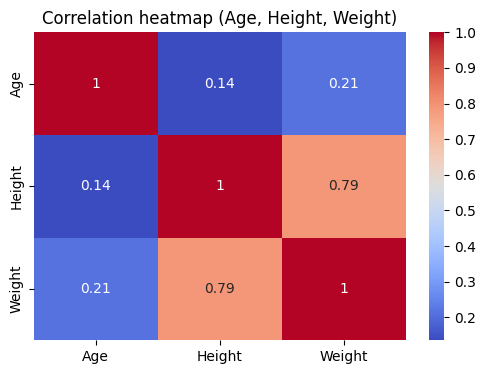

In [18]:
# correlation matrix
corr = num_sample[['Age','Height','Weight']].corr()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap (Age, Height, Weight)')
plt.show()

## 2) Logistic regression (Medal ~ Age + Height + Weight) — prepare data via SQL

In [19]:
# extract rows where Age/Height/Weight exist and Medal info
query = """
SELECT Medal IS NOT NULL AS Medal_Binary, Age, Height, Weight
FROM olympics
WHERE (Age IS NOT NULL AND Height IS NOT NULL AND Weight IS NOT NULL)
LIMIT 200000;
"""
model_df = pd.read_sql_query(query, conn)
model_df = model_df.dropna()
# convert boolean to int
model_df['Medal_Binary'] = model_df['Medal_Binary'].astype(int)
model_df.head()

,Medal_Binary,Age,Height,Weight
0,0,24.0,180.0,80.0
1,0,23.0,170.0,60.0
2,0,21.0,185.0,82.0
3,0,21.0,185.0,82.0
4,0,25.0,185.0,82.0


In [20]:
# fit logistic regression
import statsmodels.api as sm
X = sm.add_constant(model_df[['Age','Height','Weight']])
y = model_df['Medal_Binary']
logit = sm.Logit(y, X).fit(disp=False)
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:           Medal_Binary   No. Observations:               200000
Model:                          Logit   Df Residuals:                   199996
Method:                           MLE   Df Model:                            3
Date:                Sun, 26 Oct 2025   Pseudo R-squ.:                 0.01094
Time:                        21:30:02   Log-Likelihood:                -82277.
converged:                       True   LL-Null:                       -83187.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2741      0.141    -37.522      0.000      -5.550      -4.999
Age            0.0068      0.001      5.745      0.000       0.004       0.009
Height         0.0158      0.001     16.295      0.0

## 3) Medal Efficiency Index (MEI) and Age Performance Index (API) — computed using SQL aggregates

In [21]:
# MEI via SQL: medals per NOC and athletes per NOC
medals_sql = pd.read_sql_query("SELECT NOC, COUNT(Medal) AS MedalCount FROM olympics WHERE Medal IS NOT NULL GROUP BY NOC;", conn)
athletes_sql = pd.read_sql_query("SELECT NOC, COUNT(DISTINCT ID) AS NumAthletes FROM olympics GROUP BY NOC;", conn)
mei = medals_sql.merge(athletes_sql, on='NOC')
mei['MEI'] = mei['MedalCount']/mei['NumAthletes']
mei.sort_values('MEI', ascending=False).head()

,NOC,MedalCount,NumAthletes,MEI
139,URS,2503,2948,0.849050
47,GDR,1005,1360,0.738971
141,USA,5637,9653,0.583964
3,ANZ,29,53,0.547170
112,RUS,1165,2428,0.479819


In [22]:
# API via SQL: avg medalist age vs avg athlete age per sport
medalist_age = pd.read_sql_query("SELECT Sport, AVG(Age) AS AvgMedalistAge FROM olympics WHERE Medal IS NOT NULL GROUP BY Sport;", conn)
athlete_age = pd.read_sql_query("SELECT Sport, AVG(Age) AS AvgAthleteAge FROM olympics GROUP BY Sport;", conn)
api = medalist_age.merge(athlete_age, on='Sport')
api['API'] = api['AvgMedalistAge']/api['AvgAthleteAge']
api.sort_values('API', ascending=False).head()

,Sport,AvgMedalistAge,AvgAthleteAge,API
3,Archery,30.927900,27.935226,1.107129
23,Figure Skating,24.020779,22.232190,1.080450
55,Synchronized Swimming,23.809302,22.366851,1.064491
17,Cross Country Skiing,27.617268,26.006155,1.061951
18,Curling,33.302632,31.412527,1.060170


In [23]:
# save outputs
dir = Path.cwd()/'milestone3_summary'
dir.mkdir(exist_ok=True)
mei.to_csv(dir/'medal_efficiency_index.csv', index=False)
api.to_csv(dir/'age_performance_index.csv', index=False)
print('Saved MEI/API to', dir)

Saved MEI/API to c:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\notebooks\milestone3_summary


---

## Included from `milestone4_storytelling.ipynb`

# Milestone 4 — Storytelling & Presentation (SQL + Python)




In [24]:
# Setup: imports + data path
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Local data path (update if different)
data_dir = Path(r"C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data")
athletes_fp = data_dir / "athlete_events.csv"
noc_fp = data_dir / "noc_regions.csv"

print("Using data path:", athletes_fp)
if not athletes_fp.exists():
    raise FileNotFoundError(f"athlete_events.csv not found at {athletes_fp}. Place the CSV in this folder and re-run the notebook.")
# load CSV into pandas
df = pd.read_csv(athletes_fp, low_memory=False)
print("Loaded CSV with shape:", df.shape)
# standard helpers
df['Year'] = df['Year'].astype(int)
df['is_medal'] = df['Medal'].notna()


Using data path: C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data\athlete_events.csv
Loaded CSV with shape: (271116, 15)


In [25]:
conn = sqlite3.connect(':memory:')
df.to_sql('olympics', conn, index=False, if_exists='replace')


271116

## Executive Summary
This notebook pulls SQL-backed extracts and renders presentation-ready visuals.

In [26]:
# Extract top sports & top NOCs via SQL
top_sports = pd.read_sql_query("SELECT Sport, COUNT(Medal) AS medal_count FROM olympics WHERE Medal IS NOT NULL GROUP BY Sport ORDER BY medal_count DESC LIMIT 10;", conn)
top_nocs = pd.read_sql_query("SELECT NOC, COUNT(Medal) AS medal_count FROM olympics WHERE Medal IS NOT NULL GROUP BY NOC ORDER BY medal_count DESC LIMIT 10;", conn)
print('Top sports and NOCs extracted')


Top sports and NOCs extracted


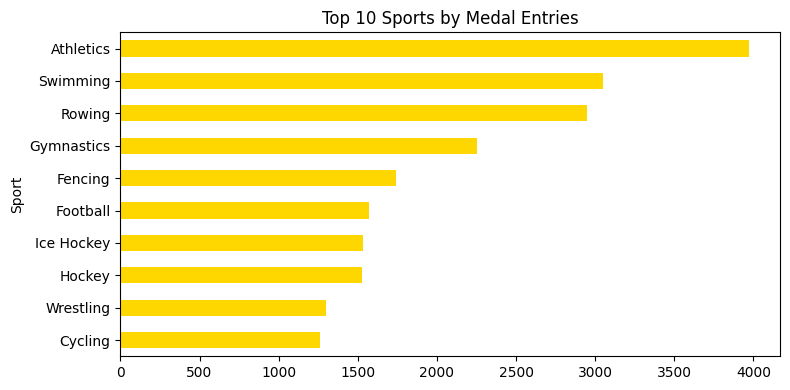

In [27]:
# Plot top sports (Python)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
top_sports.set_index('Sport')['medal_count'].sort_values().plot.barh(color='gold')
plt.title('Top 10 Sports by Medal Entries')
plt.tight_layout()
plt.show()


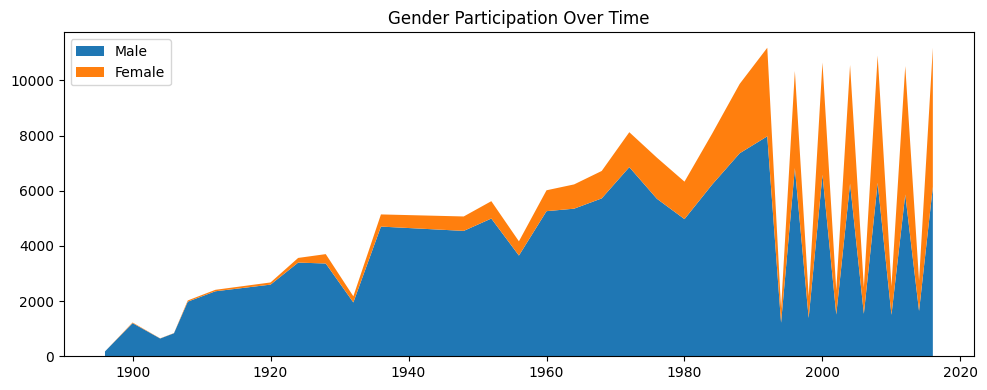

In [28]:
# Gender participation trend (SQL -> pivot -> plot)
gender_sql = pd.read_sql_query("SELECT Year, Sex, COUNT(DISTINCT ID) as athletes FROM olympics GROUP BY Year, Sex ORDER BY Year;", conn)
gender_pivot = gender_sql.pivot(index='Year', columns='Sex', values='athletes').fillna(0)
plt.figure(figsize=(10,4))
plt.stackplot(gender_pivot.index, gender_pivot.get('M',0), gender_pivot.get('F',0), labels=['Male','Female'])
plt.legend(); plt.title('Gender Participation Over Time'); plt.tight_layout(); plt.show()


## Recommendations
1. Invest in focused training programs in high-MEI countries.
2. Continue to expand female inclusion programs.
3. Build interactive dashboards for stakeholders using the saved visuals.